# AutoML solution vs single model
#### FEDOT version = 0.7.0

In [ ]:
pip install fedot==0.7.0

Below is an example of running an Auto ML solution for a classification problem.
## Description of the task and dataset

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import logging
logging.raiseExceptions = False

# Input data from csv files 
train_data_path = '../data/scoring_train.csv'
test_data_path = '../data/scoring_test.csv'
df = pd.read_csv(train_data_path)
df.head(5)

,ID,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30.59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60.89DaysPastDueNotWorse,NumberOfDependents,target
0,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
1,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
2,2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0
3,3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0
4,4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0


## Baseline model

Let's use the api features to solve the classification problem. First, we create a pipeline with a single model "xgboost". 
To do this, we will substitute the appropriate name in the predefined_model field.

Attention!
"predefined_model" - is not an initial assumption for the AutoML algorithm. It's just a single model without AutoML part

In [3]:
from fedot.api.main import Fedot

# task selection, initialisation of the framework
baseline_model = Fedot(problem='classification')

# fit model without optimisation - single XGBoost node is used 
xgb_pipeline = baseline_model.fit(features=train_data_path, target='target', predefined_model='xgboost')

# evaluate the prediction with test data
xgb_predict = baseline_model.predict_proba(features=test_data_path)

2023-03-10 16:59:10,385 - CSV data extraction - Used the column as index: "ID".
2023-03-10 16:59:15,858 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [xgboost]}
xgboost - {'eval_metric': 'mlogloss', 'nthread': -1}
Memory consumption for finish in main session: current 75.3 MiB, max: 102.8 MiB
2023-03-10 16:59:15,944 - CSV data extraction - Used the column as index: "ID".


In [4]:
from fedot.core.data.data import InputData
from sklearn.metrics import roc_auc_score

# Read data from csv file as InputData
test_data = InputData.from_csv(test_data_path)
roc_auc_baseline = roc_auc_score(test_data.target, xgb_predict)
roc_auc_baseline

2023-03-10 16:59:16,081 - CSV data extraction - Used the column as index: "ID".


0.8332360242279814

## FEDOT AutoML for classification

We can identify the model using an evolutionary algorithm built into the core of the FEDOT framework.

Here are some parameters that you can specify when initializing a class:
* problem - the name of modelling problem to solve:
        - classification
        - regression
        - ts_forecasting
        - clustering
* seed - value for fixed random seed
* logging_level - level of the output detailing
        - 50 -> critical
        - 40 -> error
        - 30 -> warning
        - 20 -> info
        - 10 -> debug
        - 0 -> nonset
* timeout - time for model design (in minutes)

In [5]:
# new instance to be used as AutoML tool
auto_model = Fedot(problem='classification', seed=42, logging_level=10, timeout=5)

In [6]:
# run of the AutoML-based model generation
pipeline = auto_model.fit(features=train_data_path, target='target')

2023-03-10 16:59:16,128 - CSV data extraction - Used the column as index: "ID".
2023-03-10 16:59:20,343 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 11.4 MiB, max: 39.0 MiB
2023-03-10 16:59:20,347 - ApiComposer - Initial pipeline was fitted in 3.1 sec.
2023-03-10 16:59:20,348 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-03-10 16:59:20,355 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 5 min. Set of candidate models: ['qda', 'fast_ica', 'logit', 'rf', 'bernb', 'dt', 'normalization', 'pca', 'isolation_forest_class', 'scaling', 'lgbm', 'knn', 'mlp', 'resample', 'poly_features', 'qda', 'fast_ica', 'logit', 'rf', 'bernb', 'dt', 'normalization', 'pca', 'isolation_forest_class', 'scaling', 'lgbm', 'knn', 'mlp', 'resample', 'poly_features'].
2023-03-10 16:59:20,360 - ApiComposer - Pipeline composition started.
2023-03-10 16:59:20,369 - DataSourceSpl

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-03-10 16:59:20,374 - MultiprocessingDispatcher - Number of used CPU's: 12
2023-03-10 16:59:30,579 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-03-10 16:59:30,581 - EvoGraphOptimizer - Generation num: 1 size: 1
2023-03-10 16:59:30,583 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.827 ComplexityMetricsEnum.node_num=0.200>']
2023-03-10 16:59:31,786 - MultiprocessingDispatcher - Number of used CPU's: 12
2023-03-10 17:01:33,839 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-03-10 17:01:33,842 - EvoGraphOptimizer - Generation num: 2 size: 21
2023-03-10 17:01:33,844 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.846 ComplexityMetricsEnum.node_num=0.200>']
2023-03-10 17:01:33,845 - EvoGraphOptimizer - Next population s

Generations:   0%|                                                                          | 1/10000 [03:26<?, ?gen/s]

2023-03-10 17:02:46,409 - OptimisationTimer - Composition time: 3.434 min
2023-03-10 17:02:46,410 - OptimisationTimer - Algorithm was terminated due to processing time limit
2023-03-10 17:02:46,412 - EvoGraphOptimizer - Generation num: 4 size: 1
2023-03-10 17:02:46,413 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.849 ComplexityMetricsEnum.node_num=0.300>']
2023-03-10 17:02:46,413 - EvoGraphOptimizer - no improvements for 1 iterations
2023-03-10 17:02:46,414 - EvoGraphOptimizer - spent time: 3.4 min
2023-03-10 17:02:46,417 - GPComposer - GP composition finished
2023-03-10 17:02:46,420 - DataSourceSplitter - K-folds cross validation is applied.
2023-03-10 17:02:46,423 - ApiComposer - Hyperparameters tuning started with 2 min. timeout
2023-03-10 17:02:46,425 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial pipeline


2023-03-10 17:03:04,495 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 3, 'nodes': [lgbm, rf, scaling]}
lgbm - {'num_leaves': 32, 'colsample_bytree': 0.8, 'subsample': 0.8, 'subsample_freq': 10, 'learning_rate': 0.03, 'n_estimators': 100}
rf - {'n_jobs': 1}
scaling - {} 
Initial metric: 0.849
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]2023-03-10 17:03:04,535 - build_posterior_wrapper took 0.012002 seconds
2023-03-10 17:03:04,537 - TPE using 0 trials
 10%|█████▋                                                   | 1/10 [00:16<02:24, 16.11s/trial, best loss: -0.8410224]2023-03-10 17:03:20,649 - build_posterior_wrapper took 0.017004 seconds
2023-03-10 17:03:20,650 - TPE using 1/1 trials with best loss -0.841022
 20%|███████████▍                                             | 2/10 [00:42<02:56, 22.09s/trial, best loss: -0.8410224]2023-03-10 17:03:46,922 - build_posterior_wrapper took 0.013003 seconds
202

In [7]:
prediction = auto_model.predict_proba(features=test_data_path)

# Calculate metric
roc_auc_auto = roc_auc_score(test_data.target, prediction)

2023-03-10 17:04:25,930 - CSV data extraction - Used the column as index: "ID".


Let see  at the pipeline.

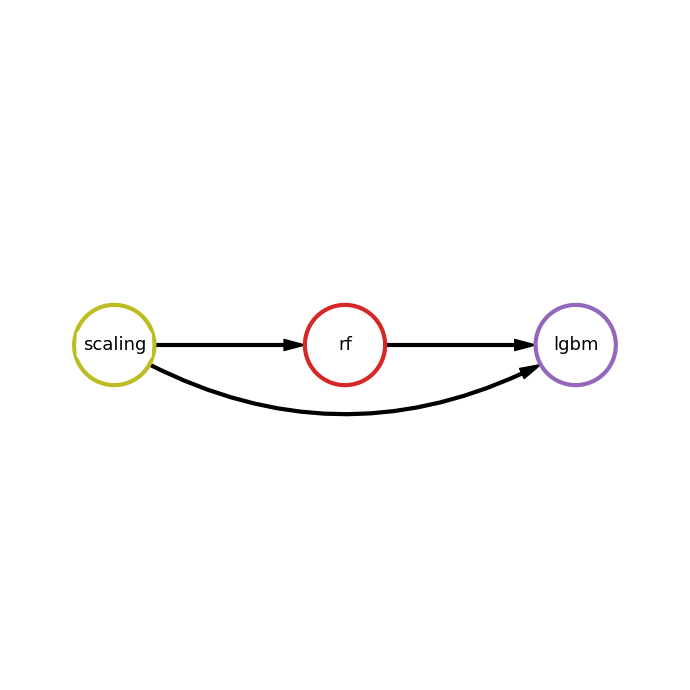

In [9]:
pipeline.show()

In [8]:
# comparison with the manual pipeline

print(f'Baseline {roc_auc_baseline:.2f}')
print(f'AutoML solution {roc_auc_auto:.2f}')

Baseline 0.83
AutoML solution 0.84


Thus, with just a few lines of code, we were able to launch the FEDOT framework and got a better result*.

*Due to the stochastic nature of the algorithm, the metrics for the found solution may differ.

If you want to learn more about FEDOT, you can use [this notebook](2_intro_to_fedot.ipynb).